# EHL

## Platform

In [70]:
from asap.ips import IP, Port, Driver, ExecutingUnit
from asap.system_platform import Platform
from asap.hw import Clock
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY


#### Platform modeling

Validating System platform: platform...
System platform is valid!


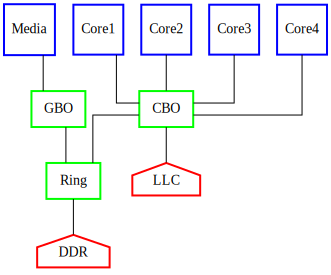

In [71]:

PENALTY_VAL = 17.36/22.76

gt_clk = Clock('gt_clock', 0.00125) # 800 MHz - 1.25 ns
core_clk = Clock('core_clock', 0.001) # 1 GHz - 1 ns
memory_clk = Clock('memory_clock', 0.0003215) # 3.2 GHz
bus_gt_clk = Clock('bus_gt_clock', 0.001) # 100 MHz
bus_core_clk = Clock('bus_core_clock', 0.001) # 100 MHz
bus_ring_clk = Clock('bus_ring_clock', 0.001)

# Buses
ring = Bus('Ring', bus_ring_clk, 64)
cbo = Bus('CBO', bus_core_clk, 64)
gbo = Bus('GBO', bus_gt_clk, 64)

# Memory
ddr = Memory('DDR', memory_clk, 4192)
llc = Memory('LLC', memory_clk, 4192)

# Platform
system_plat = Platform('platform', [memory_clk, gt_clk, core_clk, bus_core_clk, bus_gt_clk, bus_ring_clk], buses=[ring, cbo, gbo], memories=[ddr, llc])

# Ips
media_p = Port('Media_p')
media_d = Driver('Media_d', gt_clk)
media_eu = ExecutingUnit('Media_eu', gt_clk)

media = IP('Media', gt_clk, [media_eu], [media_d], [media_p])
media.connect_driver(media_d, media_p)
media.attach_attribute(PENALTY, 1)
system_plat.add_ip(media)

cores = list()
for i in range(1, 5):
    core_p = Port('Core{}_p'.format(i))
    core_d = Driver('Core{}_d'.format(i), core_clk)
    core_eu = ExecutingUnit('Core{}_eu'.format(i), core_clk)
    core = IP('Core{}'.format(i), core_clk, [core_eu], [core_d], [core_p])
    core.connect_driver(core_d, core_p)
    core.attach_attribute(PENALTY, PENALTY_VAL)
    system_plat.add_ip(core)
    system_plat.connect_to_bus(core_p, cbo)
    
# Connections
system_plat.connect_to_bus(gbo, ring)
system_plat.connect_to_bus(cbo, ring)
system_plat.connect_to_bus(media_p, gbo)
system_plat.connect_to_memory(ring, ddr)
system_plat.connect_to_memory(cbo, llc)
    
system_plat.validate_platform()
system_plat

#### CoreScheduler is responsible to map task of type "Core" to one of free cores
#### In addition, if task consists of read->proc->write, then all should work on same core (if read scheduled to core0, then proc and write must work on core0)

In [72]:
from asap.schedulers import BaseSystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState, TASK

class CoreScheduler:
    """
    Core scheduler:
    Maps core tasks to one of the available cores, and gt one to the media ip
    """
    def __init__(self, system_mgr):
        self._system_mgr = system_mgr
        self._base_scheduler = BaseSystemScheduler(self._system_mgr)
        self._cores = self._get_ips(['Core1', 'Core2', 'Core3', 'Core4'])
        self._media = self._get_ips(['Media'])[0]
        self._mappings = dict()
        
    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips
    
    def schedule_task(self, task, resources=None):
        if task.get_attribute('id') is None or (task.type == TYPES.READ and self._mappings.get(task.get_attribute('id')) is None):
            task_map_type = task.get_attribute('MAP_TYPE', None)
            if task_map_type is None:
                resource, scheduling_state = self._base_scheduler.schedule_task(task, list())
            elif task_map_type == 'GT':
                resource, scheduling_state = self._base_scheduler.schedule_task(task, [MappingEntity(task, self._media)])
            elif task_map_type == 'Core':
                resource, scheduling_state = self._base_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._cores])
            else:
                resource, scheduling_state = self._base_scheduler.schedule_task(task, list())
            if task.get_attribute('id') is not None:
                self._mappings[task.get_attribute('id')] = None
        else:
            resource, scheduling_state = self._base_scheduler.schedule_task(task, [MappingEntity(task, self._mappings[task.get_attribute('id')])])
        if task.type == TYPES.READ and self._mappings.get(task.get_attribute('id')) is None and resource is not None:
            self._mappings[task.get_attribute('id')] = resource.ip
        return resource, scheduling_state
    
    def on_task_finish(self, task):
        self._base_scheduler.on_task_finish(task)
        
    def set_schedule_task(self, task, ip):
        return self._base_scheduler.schedule_task(task, [MappingEntity(task, ip)])

In [73]:
from asap.utils import from_pnml_model, create_rpw_task
from pnets.pn_model import PnmlModel
from asap.mapping import Mapping

# Reading PNML file into PNML Model

fd = open('one_image_tg.extended.pnml', 'r')
pnml_model = PnmlModel.read(fd)

-W- Unknown attribute type for runtime: None
-W- Unknown attribute type for frequency: None
-W- Unknown attribute type for memory: None
-W- Unknown attribute type for start_delay: None


In [74]:
# Reading PNML Model into TaskGraph object and adding dynamic attributes on loading task graph

hw_resources = {'CPU': {'resource': system_plat.get_ip('Core1'), 'attributes': {'MAP_TYPE': 'Core'}}, 'GT_GFX': {'resource': media, 'attributes': {'MAP_TYPE': 'GT'}}}
reference_frequency={'CPU': 1000, 'GT_GFX': 800}
tasks_att = {'hw_resource': {'values': ['CPU', 'GT_GFX'], 'function': create_rpw_task, 'split': 1}}
taskgraph, mapping = from_pnml_model(pnml_model, 'workload', reference_frequency, hw_resources, tasks_att)


In [75]:
from speedsim import SpeedSim
from models.fabric.abstract_fabric import FabricExtension

# Setting frequencies
gt_clk.period = 0.001 # 1 GHz
core_clk.period = 0.001 # 1 GHz
bus_core_clk.period = core_clk.period
bus_gt_clk.period = gt_clk.period
bus_ring_clk.period = core_clk.period

# Running speedsim on EHL with task graph loaded from pnml
# Attaching simple fabric extension and Core scheduler mentioned above
speedsim = SpeedSim(system_plat, taskgraph, mapping, system_scheduler=CoreScheduler, extension=FabricExtension)

res = speedsim.simulate(50000000)
res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.000000,23.005531,1546/color_copy_pipe_572_572_id_0_0/read,Core1/Core1_d,0,23.005531
1,23.005531,686.590769,1546/color_copy_pipe_572_572_id_0_0/process,Core1/Core1_eu,0,663.585237
2,686.590769,693.841394,1546/color_copy_pipe_572_572_id_0_0/write,Core1/Core1_d,0,7.250625
3,693.841394,694.079394,1547/color_copy_pipe_572_572_id_0_1/read,Core1/Core1_d,0,0.238000
4,693.841394,694.899144,1550/color_copy_pipe_580_580_id_295_0/read,Core2/Core2_d,0,1.057750
5,694.079394,700.944068,1547/color_copy_pipe_572_572_id_0_1/process,Core1/Core1_eu,0,6.864675
6,700.944068,701.019084,1547/color_copy_pipe_572_572_id_0_1/write,Core1/Core1_d,0,0.075016
7,701.019084,703.293209,1554/color_copy_pipe_578_578_id_293_0/read,Core2/Core2_d,0,2.274125
8,701.019084,705.725975,1548/color_copy_pipe_572_572_id_0_2/read,Core1/Core1_d,0,4.706891
9,694.899144,710.153977,1550/color_copy_pipe_580_580_id_295_0/process,Core2/Core2_eu,0,15.254833


In [76]:
from pnets.plotting import interval_graph
from bokeh.plotting import figure, show, output_notebook
output_notebook()


Loading BokehJS ...

In [77]:
# Getting simulation time
from post_processing.utils import AnalysisData
AnalysisData.instance.max_time

490829.8447834735

In [78]:
# Drawing task analysis
clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['Core{}/Core_eu{}'.format(i, i) for i in range(4)] + ['Core{}/Core_d{}'.format(i, i) for i in range(4)] + ['Media/Media_d', 'Media/Media_eu']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)

In [79]:
# Getting ip and bus bw
ip_bw, bus_bw = speedsim.get_extension().get_bw_events()
ip_bw

,TIME,RESOURCE,BW,TARGET
0,0.000000,Core1,64000.000000,DDR
1,23.005531,Core1,64000.000000,DDR
2,686.590769,Core1,64000.000000,DDR
3,693.841394,Core1,64000.000000,DDR
4,693.841394,Core1,64000.000000,DDR
5,693.841394,Core2,32000.000000,DDR
6,694.079394,Core1,64000.000000,DDR
7,694.899144,Core2,64000.000000,DDR
8,700.944068,Core1,64000.000000,DDR
9,701.019084,Core1,64000.000000,DDR


In [80]:
bus_bw

,TIME,BUS,BW
0,0.000000,CBO,64000.0
1,0.000000,Ring,64000.0
2,23.005531,CBO,64000.0
3,23.005531,Ring,64000.0
4,686.590769,CBO,64000.0
5,686.590769,Ring,64000.0
6,693.841394,CBO,64000.0
7,693.841394,Ring,64000.0
8,693.841394,CBO,64000.0
9,693.841394,Ring,64000.0


In [81]:
# Drawing BW changes graph
from asap.strings import NAME_SEPARATOR
from bokeh.palettes import Category10
from bokeh.plotting import gridplot
from itertools import cycle

palette = cycle(Category10[10])

resources = ip_bw.RESOURCE.unique()
bws = list(ip_bw.BW.unique())
bws = list(map(lambda x: str(x), list(ip_bw.BW.unique())))
graphs = list()
for r in resources:
    s_fig = figure(plot_width=1000, plot_height=200, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=bws)
    s_fig.yaxis.axis_label = 'BW'
    subset = ip_bw.loc[ip_bw['RESOURCE'] == r, ['TIME', 'BW']]
    subset['BW'] = subset['BW'].apply(lambda x: str(x))
    s_fig.step(x=subset['TIME'].values, y=subset['BW'].values, mode='after', legend='res {}'.format(r), color=next(palette))
    graphs.append([s_fig])

show(gridplot(graphs))

In [82]:
from post_processing.utils import get_hw_analysis
from asap.strings import ResourceDesc
ip_table, ip_res = get_hw_analysis(ResourceDesc.IP)
# ip_table, ip_res = get_hw_analysis(ResourceDesc.IP, start=0, end=12303, intervals=10)
# bus_table, bus_res = get_hw_analysis(ResourceDesc.BUS, 1000)
# ip_window = window_res(ip_table, 1500, 2200)
ip_res

,0.00-490829.84
Core1/Core1_d,6.006137
Core1/Core1_eu,97.339741
Core2/Core2_d,5.059664
Core2/Core2_eu,57.455007
Media/Media_d,8.350436
Media/Media_eu,64.059137
Core3/Core3_d,2.025566
Core3/Core3_eu,15.957249
Core4/Core4_d,1.437346
Core4/Core4_eu,9.558872


In [83]:
# Changing frequencies and rerunning
gt_clk.period = 0.000625 # 1600 MHz
core_clk.period = 0.000625 # 1 GHz
bus_core_clk.period = core_clk.period
bus_gt_clk.period = gt_clk.period
bus_ring_clk.period = core_clk.period

speedsim = SpeedSim(system_plat, taskgraph, mapping, system_scheduler=CoreScheduler, extension=FabricExtension)

res = speedsim.simulate(50000000)
res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.000000,14.378457,1546/color_copy_pipe_572_572_id_0_0/read,Core1/Core1_d,0,14.378457
1,14.378457,429.119230,1546/color_copy_pipe_572_572_id_0_0/process,Core1/Core1_eu,0,414.740773
2,429.119230,433.650871,1546/color_copy_pipe_572_572_id_0_0/write,Core1/Core1_d,0,4.531641
3,433.650871,433.799621,1547/color_copy_pipe_572_572_id_0_1/read,Core1/Core1_d,0,0.148750
4,433.650871,434.311965,1550/color_copy_pipe_580_580_id_295_0/read,Core2/Core2_d,0,0.661094
5,433.799621,438.090043,1547/color_copy_pipe_572_572_id_0_1/process,Core1/Core1_eu,0,4.290422
6,438.090043,438.136928,1547/color_copy_pipe_572_572_id_0_1/write,Core1/Core1_d,0,0.046885
7,438.136928,439.558256,1554/color_copy_pipe_578_578_id_293_0/read,Core2/Core2_d,0,1.421328
8,438.136928,441.078734,1548/color_copy_pipe_572_572_id_0_2/read,Core1/Core1_d,0,2.941807
9,434.311965,443.846235,1550/color_copy_pipe_580_580_id_295_0/process,Core2/Core2_eu,0,9.534271


In [84]:
AnalysisData.instance.simulation_time

306768.6529896713

In [85]:
clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['Core{}/Core_eu{}'.format(i, i) for i in range(4)] + ['Core{}/Core_d{}'.format(i, i) for i in range(4)] + ['Media/Media_d', 'Media/Media_eu']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)